# Chapter 20 Auto Machine Learning
# Use Case: Credit Risk - Identifying Bad Credit Risks
# ===========================================

Dataset: Credit risk https://datahub.io/machine-learning/credit-g
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [2]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

We will be using Google Colab for this use-case. We first need to mount the GoogleDrive where our data is stored.

In [3]:
#Need to"mount" the right GoogleDrive ...
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/my drive/Colab Notebooks"

#ensure path is mounted and set correctly...
!echo $GOOGLE_APPLICATION_CREDENTIALS


Mounted at /content/drive
/content/my drive/Colab Notebooks


In [4]:

%cd /content/drive/MyDrive/Colab Notebooks/Data
os.listdir()

/content/drive/MyDrive/Colab Notebooks/Data


['gl_master_final_X.csv',
 'Finals',
 'Test CSV.csv',
 'credit-g.csv',
 'Ch20_AutoML.ipynb']

In [5]:
loc = "credit-g.csv"
start_time = time.time()
df = pd.read_csv(loc)
print("It took %s seconds to load the .csv file." % (time.time() - start_time))

It took 0.017042875289916992 seconds to load the .csv file.


Data Wrangling ... one hot encodings, type conversion

In [6]:
# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")

# one hot encodings
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine Dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function, to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... Make sure type is good. We change the type from str to numeric here, and any 
#df['Installs'] = pd.to_numeric(df['Installs'], errors ='coerce').fillna(0).astype('int')
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,2,22,1,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,4,40,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,4,23,1,1,1,1,0,...,0,1,0,0,0,1,0,0,0,1


## Divide DataSet: Training, Testing, Cross-validation
We will use an additional separation of our dataset for cross-validation for AutoML pipeline selection. Training data will be used for training models as usual, cross-validation data (which is held back from the training data) will be used to judge the performance of the models and pipelines selected.

Testing data we will only use for testing the final models that result from each approach so as we can judge the relative performance of each. How well will the full blown Auto-ML do?

In [7]:


from sklearn.model_selection import train_test_split

# Define X and y variables
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#>>> Extract validation set from the training data... <<<
X_train, X_cross_validation, y_train, y_cross_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=None)

# Automating Preprocessing and Model Selection

Auto-ML has several stages, principally pre-processing and model selection. We run through these stages using a limited automation process of our own, for the credit use-case.  

## Stage1: Pre-processing

Several techniques can be used to pro=process data. Here we have a simple classification problem and we address the imbalances in the dataset. There are more samples of one class than the other, so we will use SMOTE to create synthetic samples to allow us to up-sample and balance the dataset.
AutoML needs to deal with pre=processing and uses meta-learning to determine how to do this.

Get the sklearn packages we will need for our clasification problem

In [8]:
import numpy as np
import time 

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix

We can wrap data-preprocessing into a single function, where SMOTE is used to balance the classes in the dataset, and we can scale the data too.

In [9]:
# import SMOTE object
from imblearn.over_sampling import SMOTE
import numpy as np

# Wrap up balancing the dataset by up-sammpling using SMOTE, then scaling the data for the training stage.
def data_preprocess(X_train, y_train, X_cross_validation) -> (np.array, np.array, np.array):
  #Balance training data....
  # Generate SMOTE samples and use this to train
  upsampler_smote = SMOTE()
  X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

  sclr = StandardScaler()
  X_train = sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data
  
  X_train = sclr.fit_transform(X_upsampled_smote) # scale both sets:
  X_cross_validation = sclr.fit_transform(X_cross_validation)
  
  y_train = y_upsampled_smote
  
  return X_train, y_train, X_cross_validation

#Get the data in shape
X_train, y_train, X_cross_validation = data_preprocess(X_train, y_train, X_cross_validation)

## Stage2: Model selection... Choose the best F1 Score.

Now we can select the best performing classifier for our problem, based on the test data we provide, and F1 score. Note that each stage of automation we add makes the solution slightly more opaque; black-box like. We will provide salient diagnostics to help us understand the learning process.

DecisionTreeClassifier(max_depth=5)
F1 train: 0.8537, test:  0.6545
GaussianNB()
F1 train: 0.7575, test:  0.0000
LogisticRegression(max_iter=2000, random_state=0)
F1 train: 0.8632, test:  0.6139
MLPClassifier(early_stopping=True, max_iter=2000, random_state=1)
F1 train: 0.8196, test:  0.5263
RandomForestClassifier(max_depth=3, random_state=0)
F1 train: 0.8364, test:  0.5405
LinearDiscriminantAnalysis()
F1 train: 0.8667, test:  0.6071

Winner
 <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Accuracy train: 0.8710, cross-validation:  0.6857
Precision train: 0.8485, cross-validation:  0.8532
Recall train: 0.9032, cross-validation:  0.6503
F1 train: 0.8667, cross-validation:  0.6071


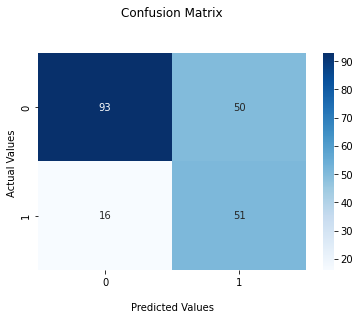

In [10]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

#Func to wrap up running these selected classification learners...
# NOTE: to test the performance of the learners out-of-sample, we should use a cross-validation dataset
# this is a hold back dataset and we will use our testing data to do this, in this case. 
def auto_classifier_selection(X_train: pd.DataFrame, X_cross_validation: pd.DataFrame, 
                            y_train: pd.DataFrame, y_cross_validation: pd.DataFrame) -> (list, list):
    
    #Balance training data....
    # Generate SMOTE samples and use this to train
    upsampler_smote = SMOTE()
    X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_upsampled_smote) # scale both sets:
    X_cross_validation = sclr.fit_transform(X_cross_validation)
    
    #Run only rf? Or all?
    dtc = DecisionTreeClassifier(max_depth=5) #If we allow endless depth we overfit
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=2000,random_state=0)
    mlp = MLPClassifier(max_iter=2000,random_state=1, early_stopping=True) # MLP will tend to overfit unless we stop early   
    rf = RandomForestClassifier(max_depth=3,random_state=0)
    lda = LinearDiscriminantAnalysis()
    
    all_mdls = [dtc,gnb,lr,mlp,rf, lda]
    
    #Find the best
    max_f1 = 0
    for mdl in all_mdls:
        #Fit model
        mdl.fit(X_upsampled_smote,y_upsampled_smote)
        y_train_hat = mdl.predict(X_upsampled_smote)
        y_cross_validation_hat = mdl.predict(X_cross_validation)       
        
        # Output model selection information....
        print(mdl)
        print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, cross-valitaion: ",
        f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}")
        
        #F1...
        this_f1 = f1_score(y_upsampled_smote,y_train_hat, average=None)[1]
        if this_f1 > max_f1:
            max_f1 = this_f1
            max_mdl = mdl
        
    # The best....
    #Fit...
    max_mdl.fit(X_upsampled_smote,y_upsampled_smote)
    y_train_hat = max_mdl.predict(X_upsampled_smote)
    y_cross_validation_hat = max_mdl.predict(X_cross_validation)
    
    #    Print score
    print('\nWinner\n', type(max_mdl))        
    print(f"Accuracy train: {max_mdl.score(X_train,y_upsampled_smote):.4f}, cross-validation: ",
      f"{max_mdl.score(X_cross_validation,y_cross_validation):.4f}")
    print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, cross-validation: ",
      f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, cross-validation: ",
      f"{recall_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, cross-validation: ",
      f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}")
        
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_cross_validation, y_cross_validation_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float')

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    
    return max_mdl, all_mdls

#Run our function....autoselect the best classifier wrt F1
max_mdl, all_models = auto_classifier_selection(X_train, X_cross_validation, y_train, y_cross_validation)

We can see the performance of each classifier on our cross-validation data printed out, with the classifier that produces the higherst F1 score chosen, and the confusion matrix of the result is printed. One additional step migth be to combine the results of the best performing classifiers into an ensemble.

## Stage3: Dimensionality reduction.

For the winning classifier, let us examine the importance of each of the input features with the aim of reducing complexity. In other words removing features that do not help our predictions. To this end, we can either reduce complexity by selecting the most influential dataitems, *feature selection*; or we can use *feature extraction*, where we reduce dimensionality, while preserving the signal.

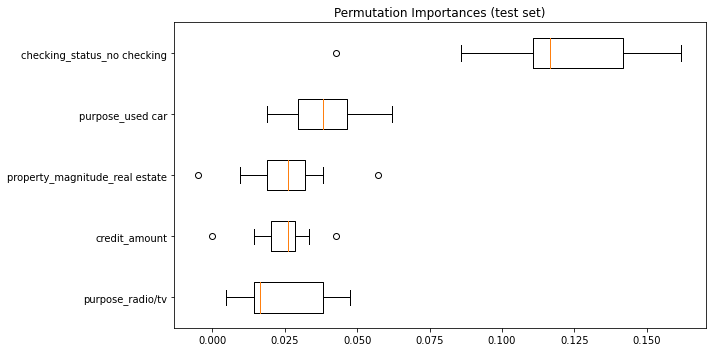

In [24]:
from sklearn.inspection import permutation_importance

# Get the importance of each input variable
result = permutation_importance(max_mdl,
                                X_cross_validation,
                                y_cross_validation,
                                n_repeats=10,
                                random_state=42,
                                n_jobs=2)
#Get the list of ordered parameters...
sorted_idx_full = result.importances_mean.argsort()

# Top 10 parameters...
sorted_idx = sorted_idx_full[-5:]

#Chart...
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()

plt.show()

Perhaps in this case we can remove a number of features

Test set performance of our selected classifier pipeline on the test dataset (ie data it has not seen before)...

LinearDiscriminantAnalysis()
F1 train: 0.9522, test:  0.4375


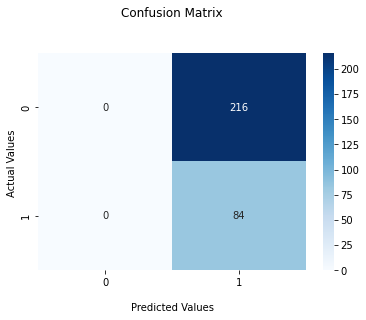

In [25]:
#Run the chosen classifier on the test dataset....
y_test_hat = max_mdl.predict(X_test)

#Confusion matrix for the AutoML model
cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

# Output model selection information....
print(max_mdl)
print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
f"{f1_score(y_test,y_test_hat, average=None)[1]:.4f}")

ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

# Full Blown Auto-ML

We have seen that automating the pre-processing, model-selection, and dimensionality reduction stages for a classification pipeline is possible but results in a more opaque, black-box outcome. However, with the right diagnostic information at each stage, we have also seen that it is possible to show how we have arrived at the final modelling-pipeline and in this way we have been able to reduce the opacity. 
AutoML takes our automation approach, and raises it to the next level. Firstly, pre-processing stages in AutoML are selected based on what has been appropriate for other problems in the past, and the data-sets provided for them. This process is called meta-learning, and our data will be ingested by the AutoML and the appropriate pre-processing will be selected based on what has been learned from other problems in the past. 
In this section we will take you through how to install Auto-SkLearn, how to run it on our credit use-case, how to generate a full machine learning pipeline for our classification problem, and how to generate diagnostic data to understand why it has done what it has done. The result will probably be effective, it will also be free of the behavioural biases and any errors we would bring as data scientists to the problem, but it will also be much more opaque that a solution we would generate manually.

## Install Auto-SkLearn

Some packages only work on certan operating systems (or containers).  Auto-SkLearn is an example, where it only runs on LINUX, the backend for Google Colab. It will not install on Windows (but it is possible to run a LINUX container on Windows).

In [12]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

for _ in range(3):
    try:
        import autosklearn.classification
        break
    except:
        pass
else:
    raise ImportError("failed to import from autosklearn")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   259  100   259    0     0   1052      0 --:--:-- --:--:-- --:--:--  1052
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-py

Lets take a look at the pre-processing options the AutoML may choose from...

In [13]:
from autosklearn.pipeline.components.feature_preprocessing import FeaturePreprocessorChoice
for name in FeaturePreprocessorChoice.get_components():
    print(name)

densifier
extra_trees_preproc_for_classification
extra_trees_preproc_for_regression
fast_ica
feature_agglomeration
kernel_pca
kitchen_sinks
liblinear_svc_preprocessor
no_preprocessing
nystroem_sampler
pca
polynomial
random_trees_embedding
select_percentile_classification
select_percentile_regression
select_rates_classification
select_rates_regression
truncatedSVD


Let us look at the classifiers that the AutoML will be selecting from

In [14]:
from autosklearn.pipeline.components.classification import ClassifierChoice
for name in ClassifierChoice.get_components():
    print(name)

adaboost
bernoulli_nb
decision_tree
extra_trees
gaussian_nb
gradient_boosting
k_nearest_neighbors
lda
liblinear_svc
libsvm_svc
mlp
multinomial_nb
passive_aggressive
qda
random_forest
sgd


Now we will pass in our training data, and get the Auto-ML to construct our entire modelling pipeline from scratch. This **TAKES A LONG TIME** to run....

In [15]:
import autosklearn.classification

#AutoML.... for classification
automl_mod = autosklearn.classification.AutoSklearnClassifier()
automl_mod.fit(X_train, y_train)
predictions = automl_mod.predict(X_cross_validation)

One run, show the leaderboard of the best performing pipelines the AUto-ML has found and tested: learners, preprocessors and other model specifications 

In [16]:
automl_mod.leaderboard(detailed = True, ensemble_only=False)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
182,1,0.06,mlp,0.172566,3.466462,181,0.081140,0,1.662382e+09,1.662382e+09,0.0,StatusType.SUCCESS,[],[extra_trees_preproc_for_classification],weighting,Random Search
23,2,0.16,passive_aggressive,0.172566,1.321625,22,0.138158,0,1.662380e+09,1.662380e+09,0.0,StatusType.SUCCESS,[],[kitchen_sinks],weighting,Initial design
143,3,0.10,adaboost,0.181416,8.450948,142,0.000000,0,1.662382e+09,1.662382e+09,0.0,StatusType.SUCCESS,[],[polynomial],none,Local Search
141,4,0.02,libsvm_svc,0.181416,1.175819,140,0.072368,0,1.662382e+09,1.662382e+09,0.0,StatusType.SUCCESS,[],[random_trees_embedding],none,Random Search
173,5,0.00,gradient_boosting,0.185841,202.240872,172,0.000000,0,1.662382e+09,1.662382e+09,0.0,StatusType.SUCCESS,[],[polynomial],weighting,Local Search
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,173,0.00,liblinear_svc,0.491150,0.879611,75,0.269737,0,1.662381e+09,1.662381e+09,0.0,StatusType.SUCCESS,[],[kitchen_sinks],none,Local Search
42,174,0.00,passive_aggressive,0.500000,1.082199,41,0.497807,0,1.662381e+09,1.662381e+09,0.0,StatusType.SUCCESS,[],[nystroem_sampler],none,Random Search
51,175,0.00,sgd,0.500000,1.017130,50,0.500000,0,1.662381e+09,1.662381e+09,0.0,StatusType.SUCCESS,[],[kitchen_sinks],weighting,Random Search


Now let us build an understaning of the training process behind the Auto-ML

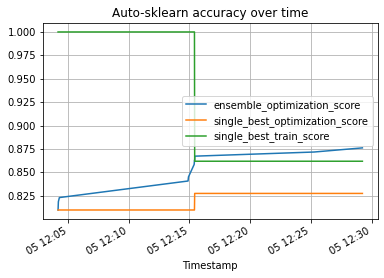

In [17]:
#Examine the training process of the AutoML
automl_mod.performance_over_time_.plot(
        x='Timestamp',
        kind='line',
        legend=True,
        title='Auto-sklearn accuracy over time',
        grid=True,
    )

In [20]:
pip install PipelineProfiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 881 kB 8.4 MB/s 
     |████████████████████████████████| 1.6 MB 40.2 MB/s 


Now examine the pipeline in detail

In [21]:
import PipelineProfiler 

# Get an interactive screen, which we can view the pre-processing, model selection, balancing schemes chosen by the AutoML 
profiler_data= PipelineProfiler.import_autosklearn(automl_mod) 
PipelineProfiler.plot_pipeline_matrix(profiler_data) 

Output hidden; open in https://colab.research.google.com to view.

Now lets look at the results..... of the best pipeline the AutoML has found

In [22]:
y_train_hat = automl_mod.predict(X_train)
y_test_hat = automl_mod.predict(X_test)

How does it compare to the classifiers we previously ran?

AutoSklearnClassifier(per_run_time_limit=360)
F1 train: 0.9522, test:  0.4906


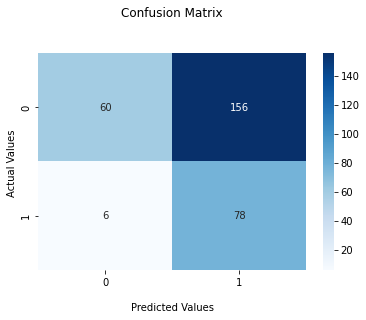

In [23]:
#Confusion matrix for the AutoML model
cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

# Output model selection information....
print(automl_mod)
print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
f"{f1_score(y_test,y_test_hat, average=None)[1]:.4f}")

ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

While neither F1 score of our own pipeline, or the AutoML pipeline are particulalry good, the AutoML pipeline shows a superior out-of-sample F1 Score.